In [132]:
import pandas as pd
import numpy as np
import mne
import pywt
import matplotlib.pyplot as plt

In [133]:
data = pd.read_csv("C:\\Users\\a1882\Desktop\EEG\open\\NN\dataset\\128_s100\\walkfocus_zyy_epocflex_2023_window_54.csv", header=None).T

In [134]:
# for column in data.columns:
#     if data[column].dtype == 'float64':
#         data[column] /= 10**6
#     elif data[column].dtype == 'int64':
#         data[column] /= 10**6

In [135]:
print(data)

             0           1           2           3          4           5    
0   -100.990974 -139.552490 -170.134048 -111.145470 -56.451145 -162.288284  \
1    -68.102295 -106.625252 -137.176224  -78.246628 -24.119308 -160.076767   
2    -35.246498  -73.730934 -104.251350  -45.380692   8.692504 -159.916702   
3    -67.486633 -105.932587 -136.422485  -77.610695 -23.591574 -192.032166   
4    -99.694534 -138.102036 -163.438370 -109.808472 -55.843365 -215.406281   
..          ...         ...         ...         ...        ...         ...   
123   -3.078546  -84.161270 -155.711227 -112.950081  -7.282609   -8.272335   
124  -27.153929 -107.643265 -177.072449 -125.644821 -18.033787  -20.559448   
125  -22.003698 -107.023315 -181.506134 -126.031487 -11.355754  -11.829658   
126   10.805998  -74.128593 -148.536942  -93.117760  21.443295   20.969864   
127   28.725962  -49.463699 -130.457626  -75.093872  46.524929   53.736588   

            6           7          8           9   ...         

In [136]:
wavelet = pywt.Wavelet('db4')

In [137]:
# filtered_data = np.zeros((32, data.shape[1]))
# for i in range(32):
#     coeffs = pywt.wavedec(data.iloc[i, :], wavelet, level=2)
#     coeffs[-1] *= 0
# #pywt.wavedec函数返回一个有序的系数数组列表，表示信号的多级离散小波分解。其中，列表中的最后一个元素是逼近系数数组，其余元素是细节系数数组
# #coeffs = pywt.wavedec(data.iloc[i, :], wavelet, level=4)将数据data.iloc[i,:]进行了4级离散小波分解，并将结果存储在名为coeffs的变量中。然后，
# #coeffs[-1] *= 0将逼近系数数组中的所有元素乘以0。
#     filtered_data[i, :] = pywt.waverec(coeffs, wavelet)

In [138]:
# coeffs = []
# for i in range(32):
#     wp = pywt.WaveletPacket(data=filtered_data[i,:], wavelet=wavelet, mode='symmetric', maxlevel=3)
#     node = wp['a']
#     coeffs.append(node.data)

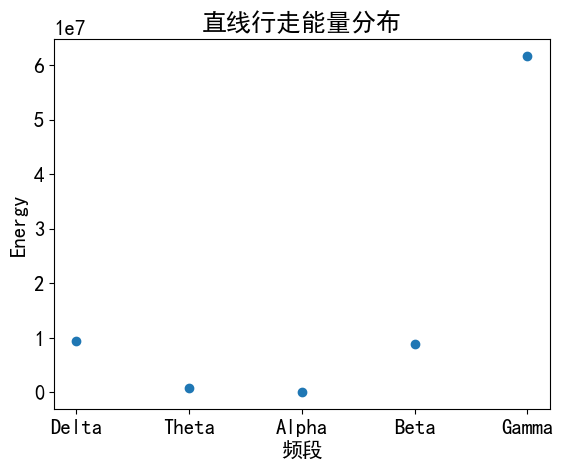

In [139]:
iter_freqs = [
    {'name': 'Delta', 'fmin': 0, 'fmax': 4},
    {'name': 'Theta', 'fmin': 4, 'fmax': 8},
    {'name': 'Alpha', 'fmin': 8, 'fmax': 13},
    {'name': 'Beta', 'fmin': 13, 'fmax': 35},
    {'name': 'Gamma', 'fmin': 35, 'fmax': 100}
    ]

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
mne.set_log_level(False)

maxlevel = 6
fs = 128
wp = pywt.WaveletPacket(data=data.iloc[1,:], wavelet='db4', mode='symmetric', maxlevel=6)

freqTree = [node.path for node in wp.get_level(6, 'freq')]

  # 计算maxlevel最小频段的带宽
freqBand = fs / (2 ** maxlevel)
    # 定义能量数组
energy = []
for iter in range(len(iter_freqs)):
        iterEnergy = 0.0
        for i in range(len(freqTree)):
            # 第i个频段的最小频率
            bandMin = i * freqBand
            # 第i个频段的最大频率
            bandMax = bandMin + freqBand
            # 判断第i个频段是否在要分析的范围内
            if (iter_freqs[iter]['fmin'] <= bandMin and iter_freqs[iter]['fmax'] >= bandMax):
                # 计算对应频段的累加和
                iterEnergy += pow(np.linalg.norm(wp[freqTree[i]].data, ord=None), 2)
        # 保存四个频段对应的能量和
        energy.append(iterEnergy)
hex_blue = '#002fc6'
plt.plot([xLabel['name'] for xLabel in iter_freqs], energy, lw=0, marker='o',)
plt.title('直线行走能量分布')
plt.ylabel('Energy')
plt.xlabel('频段')
plt.savefig("wf_energy_distribution.png", dpi=500, bbox_inches='tight')

plt.show()

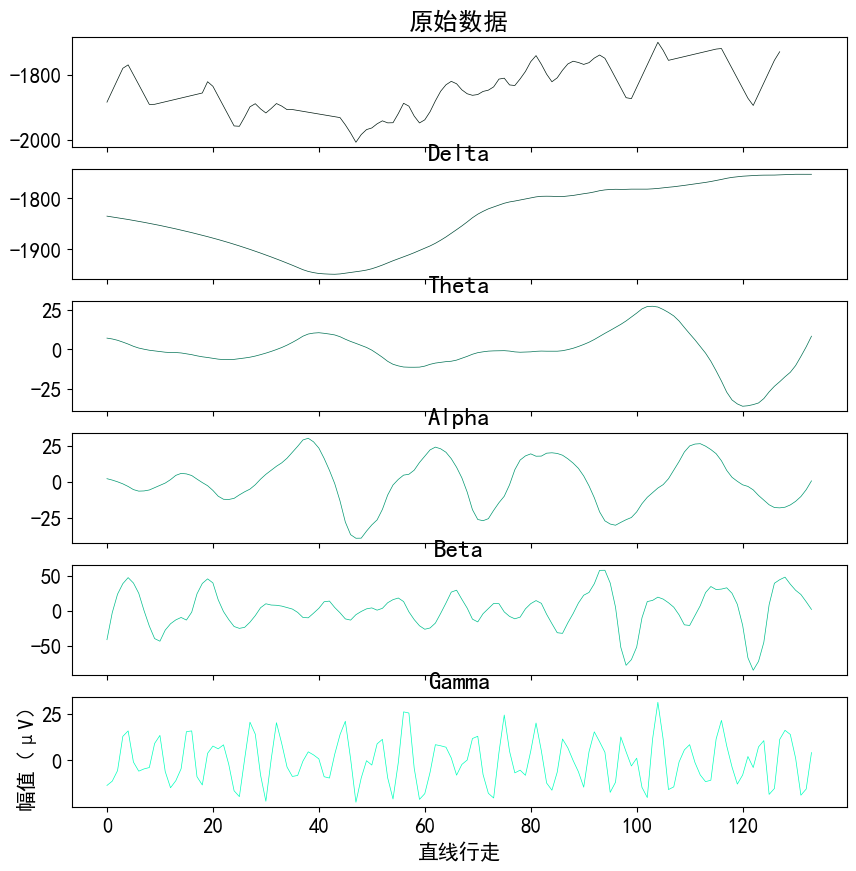

In [141]:
wp = pywt.WaveletPacket(data=data.iloc[:,28], wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
# 频谱由低到高的对应关系，这里需要注意小波变换的频带排列默认并不是顺序排列，所以这里需要使用’freq‘排序。
freqTree = [node.path for node in wp.get_level(maxlevel, 'freq')]
# 计算maxlevel最小频段的带宽
freqBand = fs/(2**maxlevel)
#######################根据实际情况计算频谱对应关系，这里要注意系数的顺序
# 绘图显示
fig, axes = plt.subplots(len(iter_freqs)+1, 1, figsize=(10, 10), sharex=True, sharey=False)
# 绘制原始数据
axes[0].plot(data.iloc[:,28], color='#001810', lw=0.5)
axes[0].set_title('原始数据')
for iter in range(len(iter_freqs)):
    # 构造空的小波包
    new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    for i in range(len(freqTree)):
        # 第i个频段的最小频率
        bandMin = i * freqBand
        # 第i个频段的最大频率
        bandMax = bandMin + freqBand
        # 判断第i个频段是否在要分析的范围内
        if (iter_freqs[iter]['fmin']<=bandMin and iter_freqs[iter]['fmax']>= bandMax):
            # 给新构造的小波包参数赋值
            new_wp[freqTree[i]] = wp[freqTree[i]].data
    # 绘制对应频率的数据
    hex_greens = ['#004b38','#007154','#009770','#00bd8c','#00ffbc']
    axes[iter+1].plot(new_wp.reconstruct(update=True),hex_greens[iter], lw=0.5)
        # 设置图名
    axes[iter+1].set_title(iter_freqs[iter]['name'])
plt.ylabel('幅值（μV）')
plt.xlabel('直线行走')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font', size=15)
plt.savefig("wf_eeg_wavelet.png", dpi=500, bbox_inches='tight')

plt.show()